<a href="https://colab.research.google.com/github/jvallalta/monai/blob/main/Clasificacion_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial de clasificación de imágenes médicas con el conjunto de datos MedNIST

En este tutorial, presentamos un ejemplo de evaluación y entrenamiento end-to-end basado en el conjunto de datos de MedNIST.

Consisitirá en los siguientes pasos:

- Crear un conjunto de datos para entrenamiento y pruebas.
- Utilice transformaciones MONAI para preprocesar datos.
- Utilice DenseNet de MONAI para la clasificación.
- Entrene el modelo con un programa PyTorch.
- Evaluar en el conjunto de datos de prueba.





# Configuración del entorno

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 606 kB 3.9 MB/s 
     |████████████████████████████████| 76 kB 3.7 MB/s 


# Imports

In [3]:
#Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.7.dev2131
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 57467c75bff90e6c9da74461f7da3a828a39626b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
tqdm version: 4.62.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Configurar directorio de datos
Puede especificar un directorio con la variable de entorno MONAI_DATA_DIRECTORY.
Esto le permite guardar resultados y reutilizar descargas.
Si no se especifica, se utilizará un directorio temporal.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpyvs2y9gz


# Descargar conjunto de datos
El conjunto de datos de MedNIST se obtuvo de varios conjuntos de TCIA, el RSNA Bone Age Challenge y el conjunto de datos de rayos X de tórax de los NIH.

El conjunto de datos fue proporcionado amablemente por el Dr. Bradley J. Erickson M.D., Ph.D. (Departamento de Radiología, Clínica Mayo) bajo la licencia Creative Commons CC BY-SA 4.0.

Si utiliza el conjunto de datos de MedNIST, reconozca la fuente.

In [5]:
resource = "https://drive.google.com/uc?id=1QsnnkvZyJPcbRoV_ArW8SnE1OTuoVbKE"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Downloading...
From: https://drive.google.com/uc?id=1QsnnkvZyJPcbRoV_ArW8SnE1OTuoVbKE
To: /tmp/tmpodlffjis/MedNIST.tar.gz
61.8MB [00:01, 36.4MB/s]


Downloaded: /tmp/tmpyvs2y9gz/MedNIST.tar.gz
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
Writing into directory: /tmp/tmpyvs2y9gz.


## Aprendizaje deterministico para reproducibilidad

In [6]:

set_determinism(seed=0)

# Leer nombres de archivos de imágenes de las carpetas del conjunto de datos
En primer lugar, verifique los archivos del conjunto de datos y muestre algunas estadísticas.
Hay 6 carpetas en el conjunto de datos: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,
que deben usarse como etiquetas para entrenar nuestro modelo de clasificación.

In [7]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


# Selección de imágenes al azar del conjunto de datos para visualizarlas y verificarlas.

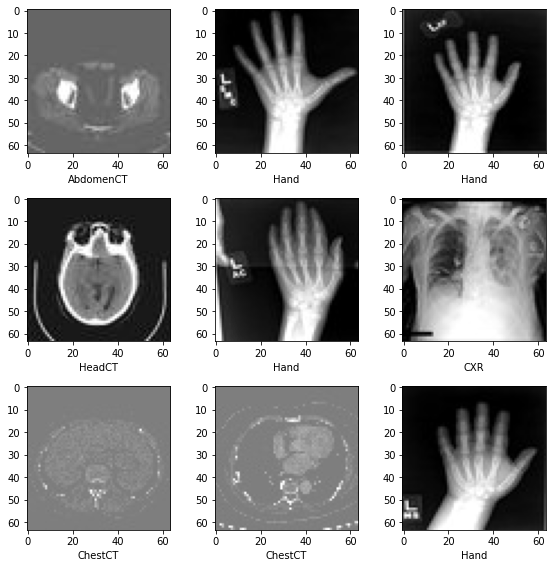

In [8]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()


# Preparación de conjuntos de training, validación y test
Selección aleatoria del 10%  del dataset como validación y 10% como test.

In [9]:

val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


# Definir transformaciones MONAI, conjunto de datos y cargador de datos para preprocesar datos

In [10]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=num_class)])

In [11]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=300, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=300, num_workers=2)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=300, num_workers=2)

# Definir red y optimizador
1. Establezca la tasa de aprendizaje de cuánto se actualiza el modelo por lote.
2. Establezca el número de época total, ya que tenemos transformaciones aleatorias y aleatorias, por lo que los datos de entrenamiento de cada época son diferentes. Y como este es solo un tutorial para comenzar, entrenemos 4 épocas.
4. Si entrena 10 épocas, el modelo puede alcanzar el 100% de precisión en el conjunto de datos de prueba.
5. Use DenseNet de MONAI y muévase al dispositivo de GPU, este DenseNet puede admitir tareas de clasificación 2D y 3D.
6. Utilice el optimizador de Adam.



In [12]:
device = torch.device("cuda:0")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()


# Entrenamiento de modelos
Ejecute un entrenamiento típico de PyTorch que ejecute un ciclo de época y un ciclo de pasos, y realice la validación después de cada época.
Guardará los pesos del modelo para archivar si obtiene la mejor precisión de validación.

In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")


----------
epoch 1/4


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1/157, train_loss: 1.7946
2/157, train_loss: 1.7593
3/157, train_loss: 1.7422
4/157, train_loss: 1.7168
5/157, train_loss: 1.6832
6/157, train_loss: 1.6584
7/157, train_loss: 1.6362
8/157, train_loss: 1.5864
9/157, train_loss: 1.5794
10/157, train_loss: 1.5627
11/157, train_loss: 1.5248
12/157, train_loss: 1.5062
13/157, train_loss: 1.4991
14/157, train_loss: 1.4715
15/157, train_loss: 1.4570
16/157, train_loss: 1.4430
17/157, train_loss: 1.3911
18/157, train_loss: 1.3836
19/157, train_loss: 1.3519
20/157, train_loss: 1.3515
21/157, train_loss: 1.3014
22/157, train_loss: 1.2930
23/157, train_loss: 1.2732
24/157, train_loss: 1.2788
25/157, train_loss: 1.2688
26/157, train_loss: 1.2577
27/157, train_loss: 1.2584
28/157, train_loss: 1.2074
29/157, train_loss: 1.1681
30/157, train_loss: 1.1545
31/157, train_loss: 1.1333
32/157, train_loss: 1.1328
33/157, train_loss: 1.1153
34/157, train_loss: 1.1043
35/157, train_loss: 1.1085
36/157, train_loss: 1.0587
37/157, train_loss: 1.0306
38/157, tr

# Gráfico de loss y métrica

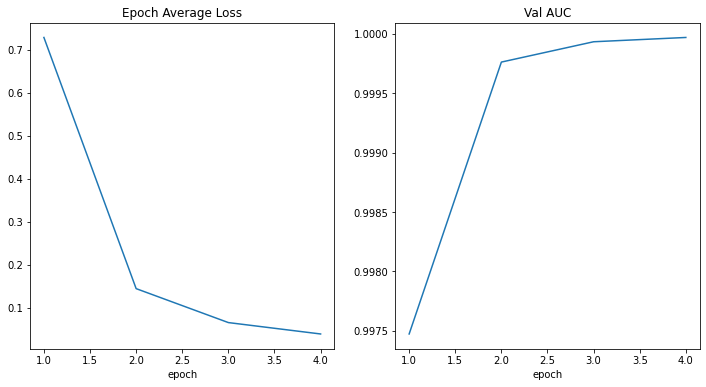

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Evaluar el modelo en el conjunto de datos de prueba
Después del entrenamiento y la validación, ya obtuvimos el mejor modelo en la prueba de validación.
Necesitamos evaluar el modelo en el conjunto de datos de prueba para verificar si es robusto y no se ajusta demasiado.
Usaremos estas predicciones para generar un informe de clasificación.

In [15]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [16]:

print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9960    0.9899    0.9929       995
   BreastMRI     1.0000    0.9966    0.9983       880
         CXR     0.9990    0.9898    0.9944       982
     ChestCT     0.9922    1.0000    0.9961      1014
        Hand     0.9905    0.9924    0.9914      1048
      HeadCT     0.9909    0.9990    0.9949       976

    accuracy                         0.9946      5895
   macro avg     0.9947    0.9946    0.9947      5895
weighted avg     0.9946    0.9946    0.9946      5895



# Limpieza de directorio de datos
Elimine el directorio si se utilizó un temporal.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)